In [43]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.optim import AdamW
from transformers import BertTokenizer, BertForSequenceClassification, get_scheduler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report, confusion_matrix, roc_curve, auc, multilabel_confusion_matrix, precision_recall_curve, average_precision_score

In [41]:
# Load your cleaned data
df = pd.read_csv('train_balanced.csv')

label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Split into input and output
X = df['clean_comment'].tolist()
y = df[label_cols].values

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print("TRAIN: ",len(X_train), "\nVAL  : ",len(X_val))

TRAIN:  170725 
VAL  :  42682


In [38]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
MAX_LEN = 150

class ToxicDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_len,
            padding='max_length',
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.FloatTensor(label)
        }

train_dataset = ToxicDataset(X_train, y_train, tokenizer, MAX_LEN)
val_dataset = ToxicDataset(X_val, y_val, tokenizer, MAX_LEN)

BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


In [39]:
# Load BERT model
# -----------------------------------------------------
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=6,
    problem_type='multi_label_classification'
)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [42]:
# Set Up Weighted BCE Loss
# -----------------------------------------------------
# Compute pos_weight
label_counts = df[label_cols].sum(axis=0)
total_samples = len(df)
pos_weight_values = (total_samples - label_counts) / (label_counts + 1e-5)
pos_weight = torch.tensor(pos_weight_values.values, dtype=torch.float32).to(device)

# Create weighted BCE loss
loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

In [45]:
optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

num_training_steps = len(train_loader) * 3  # 3 epochs

# This linearly decreases the learning rate during training for better convergence.
lr_scheduler = get_scheduler(
    name='linear',
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

In [46]:
#  Training Loop
# -----------------------------------------------------
EPOCHS = 3

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    
    for batch in tqdm(train_loader, desc=f'Training Epoch {epoch+1}'):
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        
        loss = loss_fn(logits, labels)
        total_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} Average Training Loss: {avg_loss:.4f}")

Training Epoch 1: 100%|███████████████████| 10671/10671 [16:25<00:00, 10.83it/s]


Epoch 1 Average Training Loss: 0.1430


Training Epoch 2: 100%|███████████████████| 10671/10671 [16:24<00:00, 10.84it/s]


Epoch 2 Average Training Loss: 0.0553


Training Epoch 3: 100%|███████████████████| 10671/10671 [16:24<00:00, 10.84it/s]

Epoch 3 Average Training Loss: 0.0324


In [49]:
# Evaluate
# -----------------------------------------------------
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in tqdm(val_loader, desc='Evaluating'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.sigmoid(logits)

        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Stack
y_pred = np.vstack(all_preds)
y_true = np.vstack(all_labels)

# Apply threshold 0.5
y_pred_bin = (y_pred > 0.5).astype(int)

# Classification report
print(classification_report(y_true, y_pred_bin, target_names=label_cols))

Evaluating: 100%|███████████████████████████| 2668/2668 [02:04<00:00, 21.46it/s]

               precision    recall  f1-score   support

        toxic       0.94      0.97      0.95     13319
 severe_toxic       0.95      1.00      0.97      5196
      obscene       0.95      0.99      0.97      9719
       threat       0.99      1.00      1.00      5315
       insult       0.94      0.98      0.96      9631
identity_hate       0.97      1.00      0.99      4692

    micro avg       0.95      0.98      0.97     47872
    macro avg       0.96      0.99      0.97     47872
 weighted avg       0.95      0.98      0.97     47872
  samples avg       0.31      0.31      0.31     47872




/mmfs1/project/phan/tn268/RAG/ragenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mmfs1/project/phan/tn268/RAG/ragenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/mmfs1/project/phan/tn268/RAG/ragenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.cap

In [50]:
# Save model
model.save_pretrained("model2/bert_toxic_cmt_model")
tokenizer.save_pretrained("model2/bert_toxic_cmt_model")


('model2/bert_toxic_cmt_model/tokenizer_config.json',
 'model2/bert_toxic_cmt_model/special_tokens_map.json',
 'model2/bert_toxic_cmt_model/vocab.txt',
 'model2/bert_toxic_cmt_model/added_tokens.json')

✅ Good points:

Your model detects toxic, obscene, and insult categories quite well.

Overall F1 (~0.77 micro, 0.76 weighted) is strong for multi-label text classification.

Precision is generally higher than recall → means when it predicts positive, it’s often right.

⚠️ Areas for concern:

Recall is very low for threat (0.18) and severe_toxic (0.45).

Identity_hate is also struggling (F1 = 0.55).

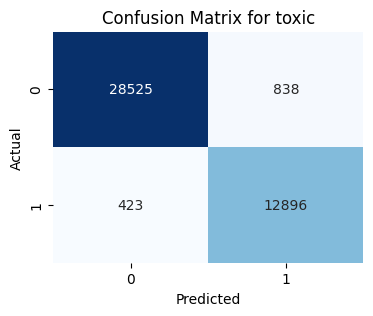

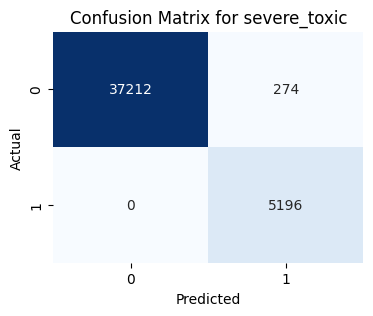

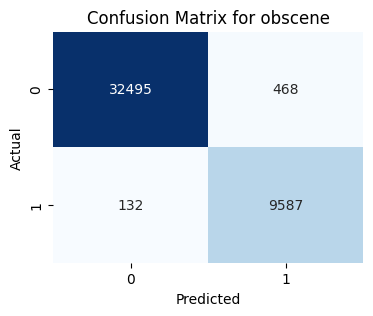

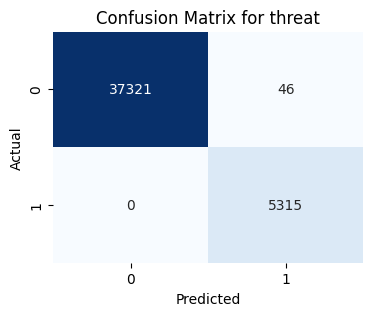

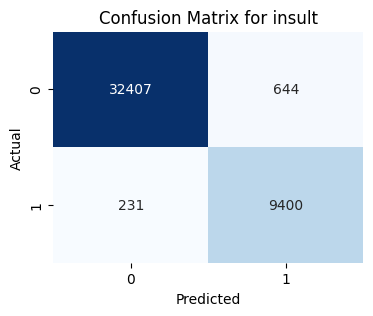

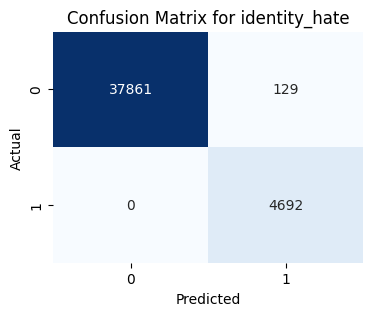

In [53]:
# Generate confusion matrices per class
conf_matrices = multilabel_confusion_matrix(y_true, y_pred_bin)

label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Plot confusion matrix for each class
for idx, label in enumerate(label_cols):
    cm = conf_matrices[idx]
    plt.figure(figsize=(4,3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f'Confusion Matrix for {label}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

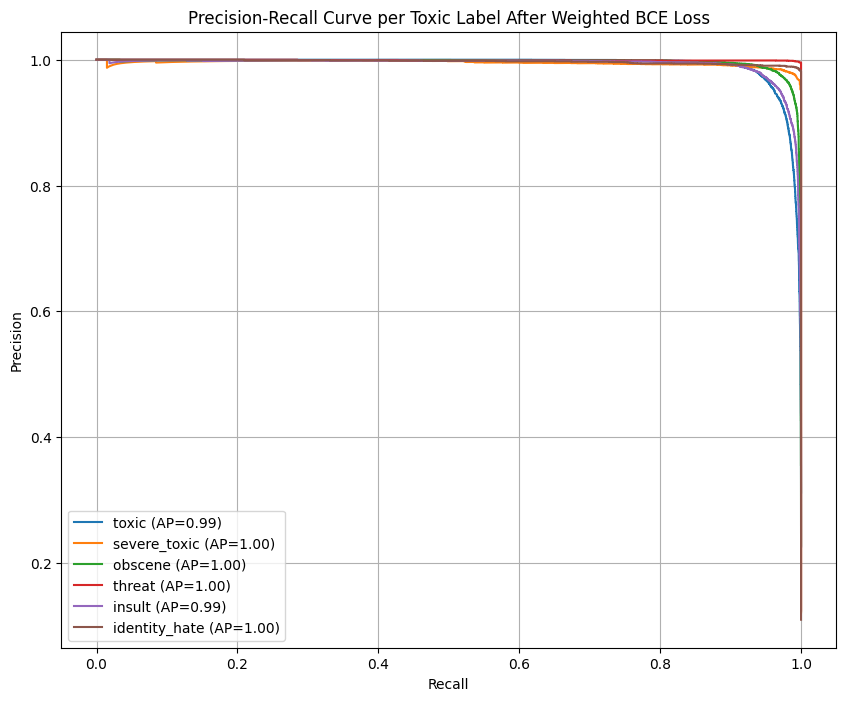

In [55]:
# Plot Precision-Recall curve for each label
plt.figure(figsize=(10, 8))

for i, label in enumerate(label_cols):
    precision, recall, _ = precision_recall_curve(y_true[:, i], y_pred[:, i])
    ap_score = average_precision_score(y_true[:, i], y_pred[:, i])

    plt.plot(recall, precision, label=f'{label} (AP={ap_score:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve per Toxic Label After Weighted BCE Loss')
plt.legend(loc='lower left')
plt.grid()
plt.show()

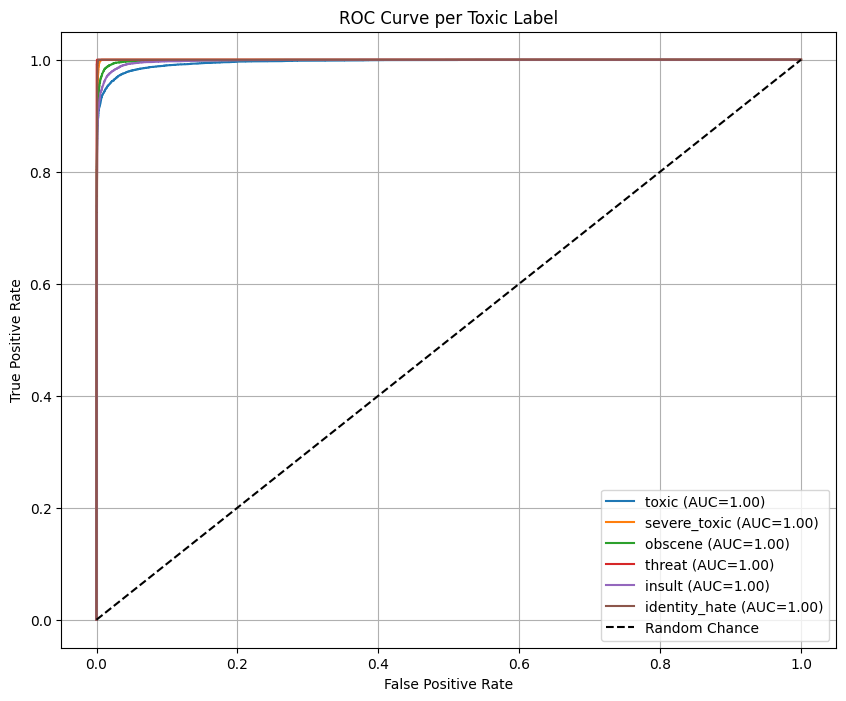

In [56]:
# Plot ROC curve for each label
plt.figure(figsize=(10, 8))

for i, label in enumerate(label_cols):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{label} (AUC={roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Toxic Label')
plt.legend(loc='lower right')
plt.grid()
plt.show()

In [32]:
for i in range(len(labels)):
    score = average_precision_score(y_true[:, i], y_pred[:, i])
    print(f"{labels[i]} PR-AUC: {score:.3f}")

toxic PR-AUC: 0.677
severe_toxic PR-AUC: 0.256
obscene PR-AUC: 0.675
threat PR-AUC: 0.139
insult PR-AUC: 0.536
identity_hate PR-AUC: 0.326


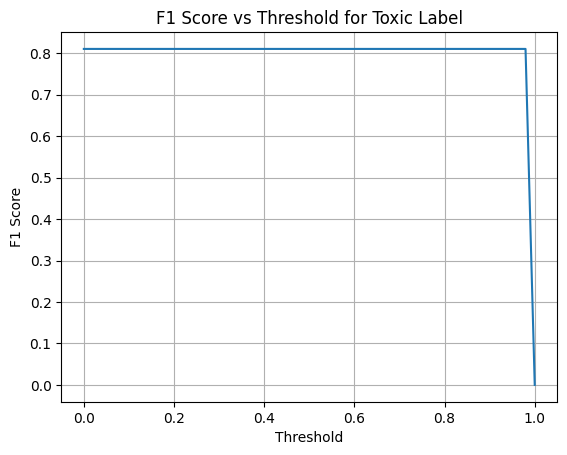

In [30]:
thresholds = np.linspace(0, 1, 50)
f1_scores = []

for threshold in thresholds:
    y_pred_bin = (y_pred[:, 0] > threshold).astype(int)  # For first label, e.g., 'toxic'
    f1 = f1_score(y_true[:, 0], y_pred_bin)
    f1_scores.append(f1)

plt.plot(thresholds, f1_scores)
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs Threshold for Toxic Label')
plt.grid()
plt.show()